## ML Geosciences - Final Project
 - **Goal**: Predict surface ocean $p$CO$_2$ from other variables provided in ROMS model (Northeast Pacific)

In [23]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

#### Open modern ROMS data files
 - **Resolution:** dx: 12km, dy: 12km, dz: 25 meters
 - **Date Range:** January 1994 - November 2007

In [2]:
path = '/ospdat/nrosen/Data'

file_modern_ROMS_ctracers = path + '/ROMS/ds_ctracers_select.nc'
file_modern_ROMS_ntracers = path + '/ROMS/ds_ntracers_select.nc'

In [3]:
ds_ctracers = xr.open_dataset(file_modern_ROMS_ctracers)
ds_ntracers = xr.open_dataset(file_modern_ROMS_ntracers)

#### Add dates to ROMS time dimension

In [4]:
def add_dates_ROMS(ds):
    ds = ds.set_coords(['lon_rho', 'lat_rho'])
    
    date1_m = "1994-01-01"
    date2_m = "2007-11-01"
    time_length_m = len(ds['ocean_time'])

    month_list_modern = [i.strftime("%B %Y") for i in pd.date_range(start=date1_m, end=date2_m, freq='MS')]
    pd_date_modern = pd.to_datetime(month_list_modern)

    ds = ds.assign_coords(time=("time", pd_date_modern))
    
    return(ds, month_list_modern)

In [5]:
ds_ctracers, month_list_modern = add_dates_ROMS(ds_ctracers)
ds_ntracers, month_list_modern = add_dates_ROMS(ds_ntracers)

#### Specify start and end dates of interest

In [7]:
specify_date = input ('Enter a modern date (start) in the format Month YYYY to define a period of time:\n')
date_index_modern_start = month_list_modern.index(specify_date)

specify_date = input ('Enter a modern date (end) in the format Month YYYY to define a period of time:\n')
date_index_modern_end = month_list_modern.index(specify_date)

Enter a modern date (start) in the format Month YYYY to define a period of time:
 December 2000
Enter a modern date (end) in the format Month YYYY to define a period of time:
 December 2001


#### Define surface driver data

In [8]:
ds_pco2 = ds_ctracers['pco2'][:,0,:,:]
ds_salt = ds_ctracers['salt'][:,0,:,:]
ds_temp = ds_ctracers['temp'][:,0,:,:]
ds_oxygen = ds_ntracers['O2'][:,0,:,:]
ds_nitrate = ds_ntracers['NO3'][:,0,:,:]
ds_phosphate = ds_ntracers['PO4'][:,0,:,:]

#### Plot ROMS data

/usr/local/anaconda3/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


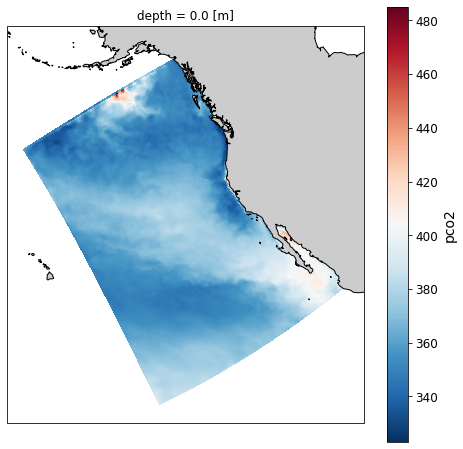

In [9]:
'''Specify input variables'''
ds = ds_ctracers
parameter = 'pco2'
depth_index = 0

'''Plot'''
fig = plt.figure(figsize = (8,8))
proj = ccrs.LambertConformal(central_longitude = -127, central_latitude = 37)
ax = fig.add_subplot(projection = proj)

cmap = matplotlib.cm.get_cmap('RdBu_r')
title_size = 14
axis_size = 12

plot_ds = ds[parameter][date_index_modern_start:date_index_modern_end+1,
                              depth_index,:,:].mean(dim='time')

model_plot = plot_ds.plot(cmap = cmap, transform = ccrs.PlateCarree(),
                         x = 'lon_rho', y = 'lat_rho', add_colorbar = False)

cbar = plt.colorbar(model_plot)#, extend = 'min')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(parameter, size = 14)
        
coast_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='0.8')
ax.add_feature(coast_50m)

- [ ] multivariate regression to get the benchmark
- [ ] Driver data - include latitude and longitude!
- [ ] Treat as stationary data
- [ ] Do a random forest or XGBoost - nodes will be number of features, start with linear regression, then single decision tree, then do XGBoost - very different style
- [ ] Find correlations between data too, think about redundancy

In [16]:
t = ds.temp[:,0,0,0]
pco2 = ds.pco2[:,0,0,0]
salt = ds.salt[:,0,0,0]

In [24]:
from sklearn.linear_model import LinearRegression


In [45]:
X = np.column_stack((t.data, salt.data))

In [46]:
reg = LinearRegression().fit(X,pco2.data)

In [47]:
reg.score(X,pco2.data)

0.7597313449643679

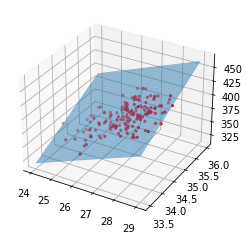

In [52]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], pco2.data, marker='.', color='red')

coef = reg.coef_
intercept = reg.intercept_

ts = np.tile(np.linspace(24,29,100),(100,1))
ss = np.tile(np.linspace(33.5,36,100),(100,1)).T
ps = ts * coef[0] + ss * coef[1] + intercept

ax.plot_surface(ts,ss,ps, alpha=0.5)
plt.show()